In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import string

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stemmer = nltk.SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/JohnnyBlaze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/JohnnyBlaze/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('/Users/JohnnyBlaze/twitter_dataset/labeled_data.csv')

df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [4]:
# Seperate Data Into Two Classes - One with Offensive & Hate Speech and the Other Without

df['class_new'] = 1  # Initialize with all ones

condition = (df['hate_speech'] == 0) & (df['offensive_language'] == 0) & (df['class'] == 2)

df.loc[condition, 'class_new'] = 0  # Select the Non-offensive Tweets

In [5]:
# Test

# df.to_csv('/Users/JohnnyBlaze/twitter_dataset/modified_data.csv', index=False)

In [6]:
# Drop Unecessary Columns

df.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class'], axis=1, inplace=True)

In [7]:
# Rename Class_New Col

df.rename(columns={'class_new': 'class'}, inplace=True)

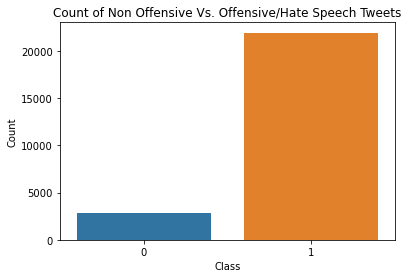

In [8]:
# Count plot for Class
sns.countplot(data=df, x='class')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Non Offensive Vs. Offensive/Hate Speech Tweets')
plt.show()

In [9]:
# Create Function for Cleaning Tweet

def tweet_cleaning(tweet):
    tweet = str(tweet).lower() # Convert tweet to lowercase
    tweet = re.sub('\[.*?\]', '', tweet) # Remove text within square brackets
    tweet = re.sub(r'^RT[\s]+', '', tweet) # Remove "RT" at the beginning of the tweet
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet) # Remove URLs starting with "http://" or "https://"
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet) # Remove URLs starting with "https://" or "www."
    tweet = re.sub('<.*?>+', '', tweet) # Remove HTML tags
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet) # Remove punctuation marks
    tweet = re.sub('\n', '', tweet) # Remove newlines
    tweet = re.sub(r'[0-9]', '', tweet) # Remove digits
    tweet = re.sub(r'#', '', tweet) # Remove hashtags
    tweet = re.sub('\w*\d\w*', '', tweet) # Remove words containing numbers
    tweet = [word for word in tweet.split(' ') if word not in stop_words] # Remove stop words
    tweet =" ".join(tweet)
    tweet = [stemmer.stem(word) for word in tweet.split(' ')] # Stem the remaining words
    tweet =" ".join(tweet)
    tweet = tweet.replace('rt', '')  # Remove "rt" from the tweet
    tweet = tweet.replace('RT', '')  # Remove "rt" from the tweet
    return tweet

In [10]:
# Create New Column Clean Tweet and Apply Cleaning

df['clean_tweet'] = df['tweet'].apply(tweet_cleaning)

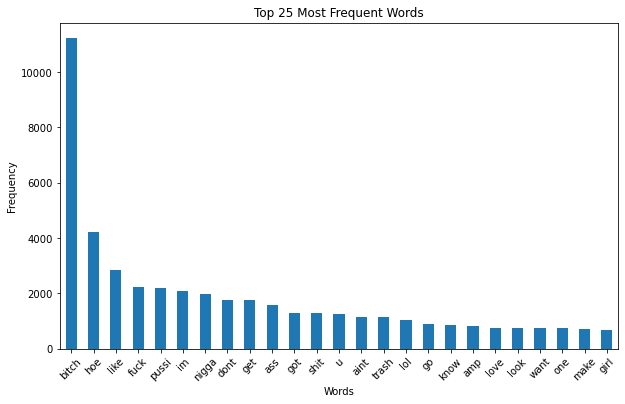

In [11]:
# Get Word Frequencies
word_frequencies = df['clean_tweet'].str.split(expand=True).stack().value_counts()

# Plot top 25
top_n = 25
top_words = word_frequencies.head(top_n)

plt.figure(figsize=(10, 6))
top_words.plot(kind='bar')
plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Top 50 Words and Their Counts
top_n = 50
top_50_words = word_frequencies.head(top_n)

print("Top 50 Words and Count:")
top_50_words

Top 50 Words and Count:


bitch     11221
hoe        4229
like       2833
fuck       2217
pussi      2183
im         2078
nigga      1976
dont       1771
get        1765
ass        1579
got        1294
shit       1282
u          1269
aint       1164
trash      1145
lol        1058
go          891
know        877
amp         837
love        760
look        758
want        745
one         741
make        703
girl        685
say         679
cant        668
yall        664
call        619
yo          612
that        612
talk        595
bird        582
your        574
bad         568
man         561
think       555
need        541
hate        535
faggot      533
good        532
see         507
time        494
still       478
ya          473
back        466
let         459
day         445
never       439
come        438
Name: count, dtype: int64

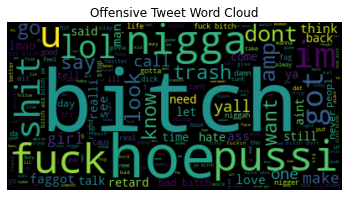

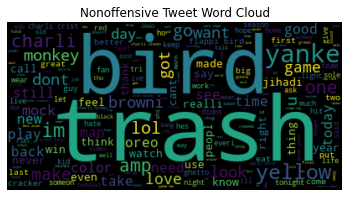

In [13]:
# Create separate text data for offensive tweets and nonoffensive tweets
text_class_1 = ' '.join(df[df['class'] == 1]['clean_tweet'])
text_class_0 = ' '.join(df[df['class'] == 0]['clean_tweet'])

# Generate Word Cloud for offensive tweets
wordcloud_class_1 = WordCloud().generate(text_class_1)
plt.imshow(wordcloud_class_1, interpolation='bilinear')
plt.axis('off')
plt.title('Offensive Tweet Word Cloud')
plt.show()

# Generate Word Cloud for nonoffensive tweets
wordcloud_class_0 = WordCloud().generate(text_class_0)
plt.imshow(wordcloud_class_0, interpolation='bilinear')
plt.axis('off')
plt.title('Nonoffensive Tweet Word Cloud')
plt.show()

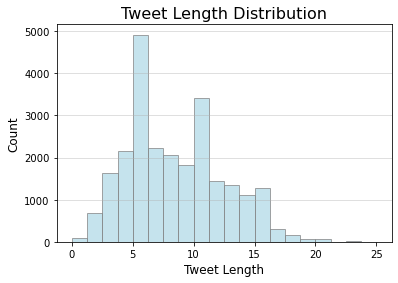

In [14]:
# Tweet Length

df['tweet_length'] = df['clean_tweet'].apply(lambda x: len(x.split()))
plt.hist(df['tweet_length'], bins=20, color='lightblue', edgecolor='gray', alpha=0.7)
plt.title('Tweet Length Distribution', fontsize=16)
plt.xlabel('Tweet Length', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.grid(axis='y', alpha=0.5)
plt.show()

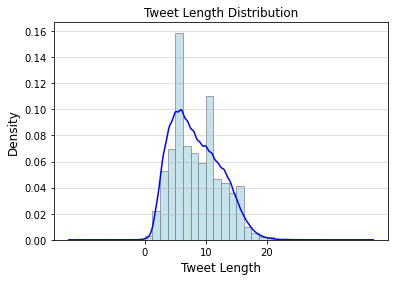

In [15]:
# Density Plot 

df['tweet_length'] = df['clean_tweet'].apply(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(6, 4))

# Histogram
ax.hist(df['tweet_length'], bins=20, density=True, color='lightblue', edgecolor='gray', alpha=0.7)

# KDE
df['tweet_length'].plot(kind='kde', color='blue')

ax.set_title('Tweet Length Distribution', fontsize=16)
ax.set_xlabel('Tweet Length', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.grid(axis='y', alpha=0.5)
ax.set_xticks(range(0, max(df['tweet_length'])+1, 10))
ax.set_xticklabels(range(0, max(df['tweet_length'])+1, 10), fontsize=10)

plt.title('Tweet Length Distribution')
plt.show()

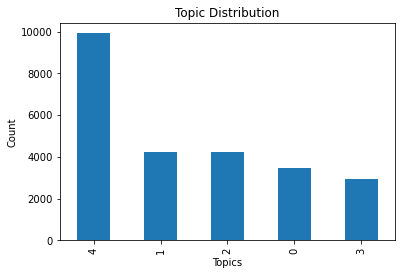

In [16]:
# Latent Dirichlet Allocation

vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(df['clean_tweet'])

lda = LatentDirichletAllocation(n_components=5)
topic_matrix = lda.fit_transform(doc_term_matrix)

topic_counts = pd.DataFrame(topic_matrix).idxmax(axis=1).value_counts()
topic_counts.plot(kind='bar')
plt.title('Topic Distribution')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.show()